**CODE LIMPIO Y ESO AQUI UNA INTRO O QUE **

In [4]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, dayofweek, date_format, avg, sum, when, lit, hour
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, TimestampType
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder \
    .appName("NYC_Taxi_Analysis") \
    .getOrCreate()

25/05/22 08:36:46 WARN Utils: Your hostname, osboxes resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/05/22 08:36:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/22 08:36:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Define helper functions from load_data.py
def add_quadrants(df):
    return df.withColumn(
        "pickup_quadrant", 
        when((col("pickup_longitude") == 0) | (col("pickup_latitude") == 0), "Invalid")
        .when((col("pickup_longitude") > -73.98) & (col("pickup_latitude") > 40.75), "NE")
        .when((col("pickup_longitude") > -73.98) & (col("pickup_latitude") <= 40.75), "SE")
        .when((col("pickup_longitude") <= -73.98) & (col("pickup_latitude") > 40.75), "NW")
        .when((col("pickup_longitude") <= -73.98) & (col("pickup_latitude") <= 40.75), "SW")
        .otherwise("Unknown")
    ).withColumn(
        "dropoff_quadrant", 
        when((col("dropoff_longitude") == 0) | (col("dropoff_latitude") == 0), "Invalid")
        .when((col("dropoff_longitude") > -73.98) & (col("dropoff_latitude") > 40.75), "NE")
        .when((col("dropoff_longitude") > -73.98) & (col("dropoff_latitude") <= 40.75), "SE")
        .when((col("dropoff_longitude") <= -73.98) & (col("dropoff_latitude") > 40.75), "NW")
        .when((col("dropoff_longitude") <= -73.98) & (col("dropoff_latitude") <= 40.75), "SW")
        .otherwise("Unknown")
    )

def load_data(path, spark):
    schema = StructType([
        StructField("VendorID", IntegerType(), True),
        StructField("tpep_pickup_datetime", TimestampType(), True),
        StructField("tpep_dropoff_datetime", TimestampType(), True),
        StructField("passenger_count", IntegerType(), True),
        StructField("trip_distance", DoubleType(), True),
        StructField("pickup_longitude", DoubleType(), True),
        StructField("pickup_latitude", DoubleType(), True),
        StructField("RatecodeID", IntegerType(), True),
        StructField("store_and_fwd_flag", StringType(), True),
        StructField("dropoff_longitude", DoubleType(), True),
        StructField("dropoff_latitude", DoubleType(), True),
        StructField("payment_type", IntegerType(), True),
        StructField("fare_amount", DoubleType(), True),
        StructField("extra", DoubleType(), True),
        StructField("mta_tax", DoubleType(), True),
        StructField("tip_amount", DoubleType(), True),
        StructField("tolls_amount", DoubleType(), True),
        StructField("improvement_surcharge", DoubleType(), True),
        StructField("total_amount", DoubleType(), True)
    ])
    df = spark.read.format("csv") \
        .option("header", "true") \
        .schema(schema) \
        .load(path)
    print("Sample of original data:")
    df.show(5)
    df_with_quadrants = add_quadrants(df)
    df_with_days = df_with_quadrants.withColumn(
        "day_of_week", 
        date_format(col("tpep_pickup_datetime"), "EEEE")
    )
    return df_with_days

In [6]:
# Load the data
file_path = "/home/osboxes/Downloads/project/yellow_tripdata_2015-01.csv"
df = load_data(file_path, spark)

Sample of original data:


+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RatecodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       2| 2015-01-15 19:05:39|  2015-01-15 19:23:42|              1|         1.59|  -73.993896484375|  40.7501106262207|         1|    


Most common routes (pickup to dropoff):


+---------------+----------------+-------+
|pickup_quadrant|dropoff_quadrant|  count|
+---------------+----------------+-------+
|             NE|              NE|2877644|
|             SW|              SW|2401525|
|             NW|              NE| 915466|
|             SW|              NE| 884741|
|             NE|              SW| 776061|
|             NE|              NW| 775022|
|             NW|              NW| 730502|
|             SW|              NW| 622817|
|             NW|              SW| 597899|
|             SW|              SE| 535123|
+---------------+----------------+-------+
only showing top 10 rows



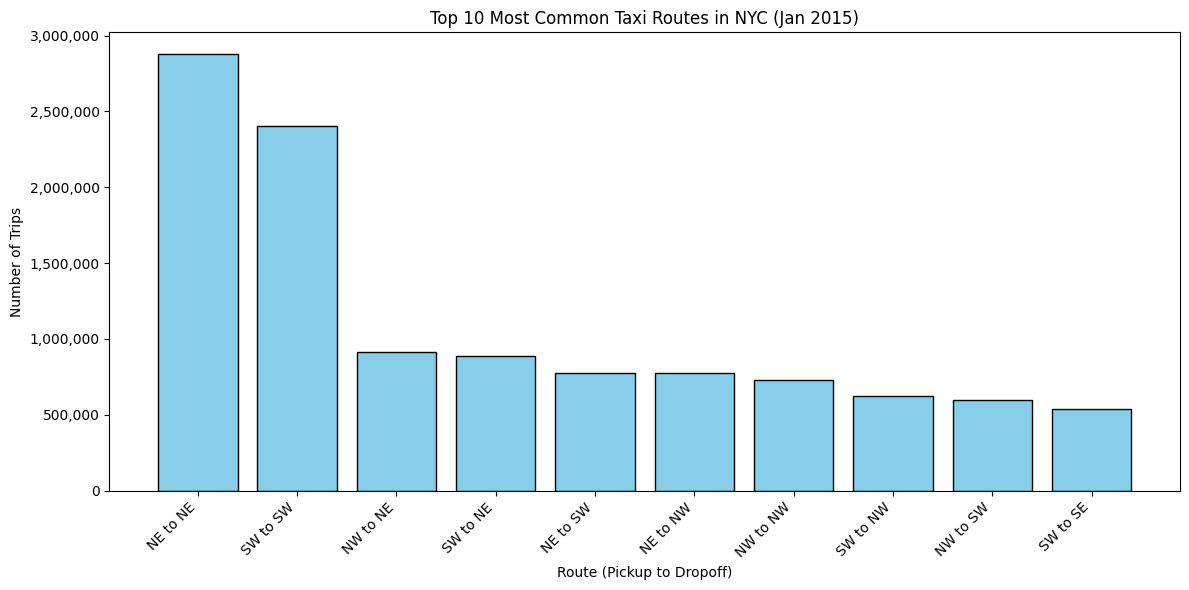

In [9]:
# Query 1: Most Common Routes (pickup_quadrant to dropoff_quadrant)
def query_1():
    result = df.groupBy("pickup_quadrant", "dropoff_quadrant") \
        .count() \
        .orderBy(col("count").desc())
    print("\nMost common routes (pickup to dropoff):")
    result.show(10)
    
    # Convert to Pandas for plotting
    result_pd = result.limit(10).toPandas()
    result_pd['route'] = result_pd['pickup_quadrant'] + ' to ' + result_pd['dropoff_quadrant']
    
    # Create static bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(result_pd['route'], result_pd['count'], color='skyblue', edgecolor='black')
    plt.xlabel('Route (Pickup to Dropoff)')
    plt.ylabel('Number of Trips')
    plt.title('Top 10 Most Common Taxi Routes in NYC (Jan 2015)')
    plt.xticks(rotation=45, ha='right')
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
    plt.tight_layout()
    plt.show()
    
    return result_pd

# Run Query 1
result_q1 = query_1()

Conclusions for Query 1
Based on the results and the plot:

- Dominant Routes: The top two routes, "NE to NE" (2,877,644 trips) and "SW to SW" (2,401,525 trips), account for a significant portion of trips. These quadrants likely cover central Manhattan (e.g., NE for Upper East Side/Midtown, SW for Lower Manhattan), where taxi demand is highest.
Intra-Quadrant Travel: Most common routes are within the same quadrant (e.g., NE to NE, SW to SW, NW to NW), suggesting many trips are short or localized within busy areas.
- Inter-Quadrant Travel: Routes like "NW to NE" (915,466) and "SW to NE" (884,741) indicate frequent travel between quadrants, possibly reflecting commutes to business districts (e.g., from NW to NE for Midtown offices).
- Business Insight: Taxi companies should prioritize driver availability in NE and SW quadrants, as they have the highest demand. Inter-quadrant routes (e.g., SW to NE) suggest potential for targeted services, like airport shuttles from Lower Manhattan to Midtown.
- Data Quality: The absence of "Invalid" or "Unknown" in the top 10 routes is a good sign, but you should check the full dataset for such entries to ensure coordinate accuracy.
- Next Steps: Cross-reference with Query 4 (pickups by hour) to see if these routes peak at specific times (e.g., rush hours). Also, compare with Query 3 to check if high-traffic routes correlate with high income.